# Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/kaggle/2025-bamboo-summer-competiton-dl-pr.zip'
extract_path = '/content/drive/MyDrive/kaggle/2025-bamboo-summer-competiton-dl-pr'

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os, random, numpy as np, pandas as pd, torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
import timm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
from copy import deepcopy
from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [ ]:
!pip install timm==0.9.16

In [ ]:
CFG = {
    'IMG_SIZE'    : 224,
    'EPOCHS'      : 20,
    'SEED'        : 42,
    'BATCH_SIZE'  : 32,
    'NUM_WORKERS' : 2,
    'BACKBONE'    : 'convnext_tiny.fb_in22k',  # timm 모델 이름
    'LR'          : 1e-4,
    'WEIGHT_DECAY': 1e-5,
}

In [ ]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# Data Load

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/kaggle/2025-bamboo-summer-competiton-dl-pr/train.csv")
test = pd.read_csv("/content/drive/MyDrive//kaggle/2025-bamboo-summer-competiton-dl-pr/test.csv")

# 라벨 인코딩
le = LabelEncoder()
train["label_encoded"] = le.fit_transform(train["label"])

train.head()

,filename,label,label_encoded
0,image_0001.jpg,MANGROVE SKIPPER,40
1,image_0002.jpg,GREAT JAY,32
2,image_0003.jpg,SLEEPY ORANGE,64
3,image_0004.jpg,CLEOPATRA,17
4,image_0005.jpg,PAINTED LADY,49


# Custom Dataset

In [ ]:
class ButterflyDataset(Dataset):
    def __init__(self, df, img_dir, transform, train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir, self.transform, self.train = img_dir, transform, train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row['filename'])).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, row['label_encoded']
        else:
            return img, row['filename']

# Preprocessing
- Train data 증강

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(CFG['IMG_SIZE'], scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.15, 0.15, 0.15, 0.05),

    transforms.ToTensor(),                                    # ① Tensor로 변환
    transforms.Normalize([0.485,0.456,0.406],                 # ② 정규화
                         [0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.08)),      # ③ 마지막에 Erasing
])

val_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

TRAIN_DIR = "/content/drive/MyDrive/kaggle/2025-bamboo-summer-competiton-dl-pr/train"  # 이미지 폴더 경로
TEST_DIR  = "/content/drive/MyDrive/kaggle/2025-bamboo-summer-competiton-dl-pr/test"

# Data Split

In [ ]:
# train/val 8:2로 stratify 분할
train_df, val_df = train_test_split(
    train,
    test_size=0.2,
    stratify=train["label_encoded"]
)

In [ ]:
#시각화를 위한 변수
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss'  : [], 'val_acc' : []
}

# 데이터셋 및 데이터로더
train_ds = ButterflyDataset(train_df, TRAIN_DIR, train_transform, train=True)
val_ds   = ButterflyDataset(val_df, TRAIN_DIR, val_transform, train=True)

train_ld = DataLoader(train_ds, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])
val_ld   = DataLoader(val_ds, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

# 모델, 손실 함수, 옵티마이저
model = timm.create_model(CFG['BACKBONE'], pretrained=True, num_classes=len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG['LR'], weight_decay=CFG['WEIGHT_DECAY'])
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['EPOCHS'])

best_acc, best_state = 0, None

for epoch in range(CFG['EPOCHS']):
    # ---- Train ----
    model.train(); run_loss = 0; correct = total = 0
    for imgs, labels in tqdm(train_ld, desc=f"Epoch {epoch+1}/{CFG['EPOCHS']}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):          # ← FutureWarning 해결
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        run_loss += loss.item() * imgs.size(0)
        correct  += outputs.argmax(1).eq(labels).sum().item()
        total    += labels.size(0)
    scheduler.step()

    train_loss = run_loss / total
    train_acc  = correct / total

    # ---- Val ----
    model.eval(); v_loss = 0; v_correct = v_total = 0
    with torch.no_grad():
        for imgs, labels in val_ld:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)

            v_loss    += loss.item() * imgs.size(0)
            v_correct += outputs.argmax(1).eq(labels).sum().item()
            v_total   += labels.size(0)

    val_loss = v_loss / v_total
    val_acc  = v_correct / v_total

    # --- 기록 ---
    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    history['val_loss']  .append(val_loss);   history['val_acc']  .append(val_acc)

    print(f"Epoch {epoch+1:02d} | "
          f"TLoss {train_loss:.4f} TAcc {train_acc:.3f} | "
          f"VLoss {val_loss:.4f} VAcc {val_acc:.3f}")

    if val_acc > best_acc:
        best_acc, best_state = val_acc, deepcopy(model.state_dict())
        print(f"New Best! {best_acc:.4f}")

/tmp/ipython-input-44-1232143042.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20: 100%|██████████| 130/130 [00:55<00:00,  2.35it/s]


Epoch 01 | TLoss 2.3681 TAcc 0.566 | VLoss 0.8334 VAcc 0.866
New Best! 0.8663


Epoch 2/20: 100%|██████████| 130/130 [00:50<00:00,  2.60it/s]


Epoch 02 | TLoss 0.5009 TAcc 0.910 | VLoss 0.4091 VAcc 0.917
New Best! 0.9173


Epoch 3/20: 100%|██████████| 130/130 [00:55<00:00,  2.34it/s]


Epoch 03 | TLoss 0.2480 TAcc 0.948 | VLoss 0.3433 VAcc 0.920
New Best! 0.9202


Epoch 4/20: 100%|██████████| 130/130 [00:52<00:00,  2.48it/s]


Epoch 04 | TLoss 0.1588 TAcc 0.966 | VLoss 0.2827 VAcc 0.930
New Best! 0.9298


Epoch 5/20: 100%|██████████| 130/130 [00:53<00:00,  2.42it/s]


Epoch 05 | TLoss 0.1129 TAcc 0.976 | VLoss 0.2700 VAcc 0.932
New Best! 0.9317


Epoch 6/20: 100%|██████████| 130/130 [00:51<00:00,  2.53it/s]


Epoch 06 | TLoss 0.0858 TAcc 0.981 | VLoss 0.2602 VAcc 0.939
New Best! 0.9394


Epoch 7/20: 100%|██████████| 130/130 [00:50<00:00,  2.57it/s]


Epoch 07 | TLoss 0.0606 TAcc 0.987 | VLoss 0.2471 VAcc 0.935


Epoch 8/20: 100%|██████████| 130/130 [00:50<00:00,  2.60it/s]


Epoch 08 | TLoss 0.0451 TAcc 0.990 | VLoss 0.2511 VAcc 0.938


Epoch 9/20: 100%|██████████| 130/130 [00:51<00:00,  2.50it/s]


Epoch 09 | TLoss 0.0443 TAcc 0.991 | VLoss 0.2654 VAcc 0.933


Epoch 10/20: 100%|██████████| 130/130 [00:52<00:00,  2.50it/s]


Epoch 10 | TLoss 0.0305 TAcc 0.993 | VLoss 0.2366 VAcc 0.939


Epoch 11/20: 100%|██████████| 130/130 [00:51<00:00,  2.54it/s]


Epoch 11 | TLoss 0.0275 TAcc 0.994 | VLoss 0.2527 VAcc 0.937


Epoch 12/20: 100%|██████████| 130/130 [00:51<00:00,  2.52it/s]


Epoch 12 | TLoss 0.0189 TAcc 0.997 | VLoss 0.2285 VAcc 0.943
New Best! 0.9433


Epoch 13/20: 100%|██████████| 130/130 [00:53<00:00,  2.44it/s]


Epoch 13 | TLoss 0.0136 TAcc 0.998 | VLoss 0.2287 VAcc 0.943


Epoch 14/20: 100%|██████████| 130/130 [00:51<00:00,  2.54it/s]


Epoch 14 | TLoss 0.0137 TAcc 0.998 | VLoss 0.2354 VAcc 0.937


Epoch 15/20: 100%|██████████| 130/130 [00:51<00:00,  2.51it/s]


Epoch 15 | TLoss 0.0116 TAcc 0.998 | VLoss 0.2264 VAcc 0.944
New Best! 0.9442


Epoch 16/20: 100%|██████████| 130/130 [00:51<00:00,  2.50it/s]


Epoch 16 | TLoss 0.0107 TAcc 0.998 | VLoss 0.2243 VAcc 0.943


Epoch 17/20: 100%|██████████| 130/130 [00:52<00:00,  2.45it/s]


Epoch 17 | TLoss 0.0087 TAcc 0.998 | VLoss 0.2292 VAcc 0.947
New Best! 0.9471


Epoch 18/20: 100%|██████████| 130/130 [00:51<00:00,  2.53it/s]


Epoch 18 | TLoss 0.0088 TAcc 0.998 | VLoss 0.2263 VAcc 0.946


Epoch 19/20: 100%|██████████| 130/130 [00:52<00:00,  2.48it/s]


Epoch 19 | TLoss 0.0081 TAcc 0.999 | VLoss 0.2265 VAcc 0.945


Epoch 20/20: 100%|██████████| 130/130 [00:54<00:00,  2.38it/s]


Epoch 20 | TLoss 0.0081 TAcc 0.999 | VLoss 0.2267 VAcc 0.945


# Loss &  Accuracy 시각화

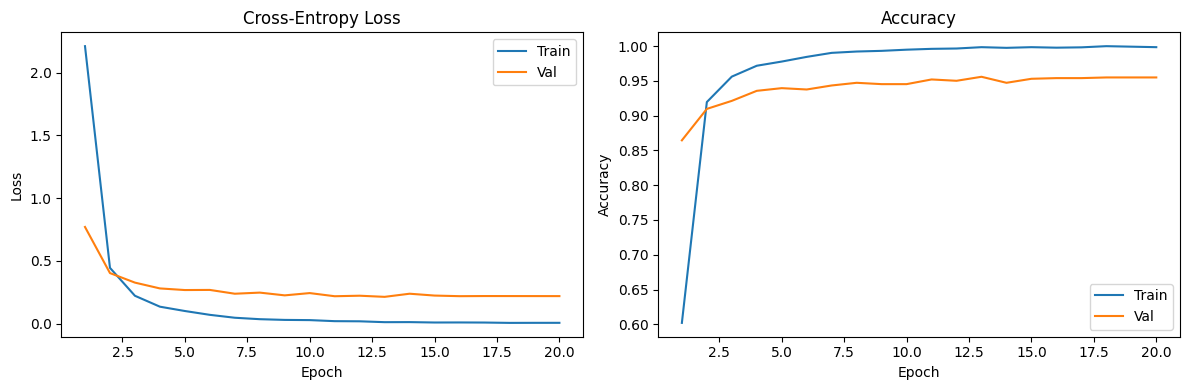

In [ ]:
epochs = range(1, CFG['EPOCHS']+1)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train')
plt.plot(epochs, history['val_loss'],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Cross-Entropy Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train')
plt.plot(epochs, history['val_acc'],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

In [ ]:
# ── 데이터 결합 및 DataLoader ───────────────────────────────────────────
full_df = pd.concat([train_df, val_df], ignore_index=True)

full_ds = ButterflyDataset(full_df, TRAIN_DIR,
                           train_transform,   # 그대로 증강 적용
                           train=True)

full_ld = DataLoader(full_ds,
                     batch_size=CFG['BATCH_SIZE'],
                     shuffle=True,
                     num_workers=CFG['NUM_WORKERS'],
                     pin_memory=True)

# ── 베스트 가중치 로드 & 옵티마이저 재초기화 ─────────────────────────
model.load_state_dict(best_state)

optimizer = optim.AdamW(model.parameters(),
                        lr=CFG['LR'],
                        weight_decay=CFG['WEIGHT_DECAY'])

# GradScaler: device_type 인자 제거
scaler = torch.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=CFG['EPOCHS'])


full_hist = {'loss': [], 'acc': []}
FULL_EPOCHS = CFG['EPOCHS']

# ── 학습 루프 ─────────────────────────────────────────────────────────
for epoch in range(1, FULL_EPOCHS+1):
    model.train(); run_loss = 0; correct = total = 0
    for imgs, labels in tqdm(full_ld, desc=f"[Full] {epoch}/{FULL_EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        run_loss += loss.item() * imgs.size(0)
        correct  += outputs.argmax(1).eq(labels).sum().item()
        total    += labels.size(0)

    scheduler.step()
    epoch_loss = run_loss / total
    epoch_acc  = correct / total
    full_hist['loss'].append(epoch_loss)
    full_hist['acc'] .append(epoch_acc)

    print(f"[Full] Epoch {epoch:02d} | Loss {epoch_loss:.4f} | Acc {epoch_acc:.3f}")

# ── 최종 모델 저장 ────────────────────────────────────────────────────
torch.save(model.state_dict(), "convnext_tiny_full.pth")

[Full] 1/20: 100%|██████████| 163/163 [01:03<00:00,  2.55it/s]


[Full] Epoch 01 | Loss 0.1040 | Acc 0.976


[Full] 2/20: 100%|██████████| 163/163 [01:03<00:00,  2.58it/s]


[Full] Epoch 02 | Loss 0.0562 | Acc 0.986


[Full] 3/20: 100%|██████████| 163/163 [01:03<00:00,  2.57it/s]


[Full] Epoch 03 | Loss 0.0449 | Acc 0.987


[Full] 4/20: 100%|██████████| 163/163 [01:00<00:00,  2.67it/s]


[Full] Epoch 04 | Loss 0.0346 | Acc 0.991


[Full] 5/20: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]


[Full] Epoch 05 | Loss 0.0267 | Acc 0.993


[Full] 6/20: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]


[Full] Epoch 06 | Loss 0.0244 | Acc 0.993


[Full] 7/20: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]


[Full] Epoch 07 | Loss 0.0227 | Acc 0.993


[Full] 8/20: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]


[Full] Epoch 08 | Loss 0.0183 | Acc 0.996


[Full] 9/20: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]


[Full] Epoch 09 | Loss 0.0168 | Acc 0.996


[Full] 10/20: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]


[Full] Epoch 10 | Loss 0.0088 | Acc 0.998


[Full] 11/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


[Full] Epoch 11 | Loss 0.0066 | Acc 0.998


[Full] 12/20: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]


[Full] Epoch 12 | Loss 0.0067 | Acc 0.998


[Full] 13/20: 100%|██████████| 163/163 [00:58<00:00,  2.77it/s]


[Full] Epoch 13 | Loss 0.0118 | Acc 0.997


[Full] 14/20: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]


[Full] Epoch 14 | Loss 0.0079 | Acc 0.998


[Full] 15/20: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


[Full] Epoch 15 | Loss 0.0050 | Acc 0.998


[Full] 16/20: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


[Full] Epoch 16 | Loss 0.0042 | Acc 0.999


[Full] 17/20: 100%|██████████| 163/163 [00:58<00:00,  2.77it/s]


[Full] Epoch 17 | Loss 0.0040 | Acc 0.999


[Full] 18/20: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]


[Full] Epoch 18 | Loss 0.0037 | Acc 0.999


[Full] 19/20: 100%|██████████| 163/163 [00:59<00:00,  2.72it/s]


[Full] Epoch 19 | Loss 0.0037 | Acc 0.998


[Full] 20/20: 100%|██████████| 163/163 [00:59<00:00,  2.74it/s]


[Full] Epoch 20 | Loss 0.0029 | Acc 0.999


# Inference

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

In [ ]:
test_ds  = ButterflyDataset(test, TEST_DIR, test_transform, train=False)
test_ld  = DataLoader(test_ds,
                      batch_size=CFG['BATCH_SIZE'],
                      shuffle=False,
                      num_workers=CFG['NUM_WORKERS'],
                      pin_memory=True)

ButterflyDataset(train_df, TRAIN_DIR, train_transform, train=True)

In [ ]:
NUM_CLASSES = len(le.classes_)
model = timm.create_model(CFG['BACKBONE'], pretrained=False, num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load("convnext_tiny_full.pth"))
model.eval()
pred_labels, pred_files = [], []

with torch.no_grad():
    for imgs, fnames in tqdm(test_ld, desc="Predicting"):
        imgs = imgs.to(device)

        logits = model(imgs)
        preds  = torch.argmax(logits, dim=1).cpu().numpy()        # 정수 ID
        labels = le.inverse_transform(preds)                      # 문자열 라벨

        pred_labels.extend(labels)
        pred_files.extend(fnames)

Predicting: 100%|██████████| 41/41 [00:10<00:00,  4.09it/s]


# Submit

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/kaggle/2025-bamboo-summer-competiton-dl-pr/sample_submission.csv')
submission['label'] = pred_labels
submission.to_csv("/content/drive/MyDrive/kaggle/final_submission.csv", index=False)
print("✅ submission.csv 생성 완료!")

✅ submission.csv 생성 완료!
